In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
%matplotlib inline

In [6]:
words = open('names.txt', 'r').read().splitlines()

chars = sorted(list(set("".join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i:s for s,i in stoi.items()}

In [8]:
def build_dataset(words):
    context_len = 3
    X, Y = [], []
    
    for w in words:
        context = [0] * context_len
    
        for l in w + '.':
            ix = stoi[l]
            X.append(context)
            Y.append(ix)
            # print(''.join([itos[i] for i in context]), "->", itos[ix])
            context = context[1:] + [ix]
        
    X, Y = torch.tensor(X), torch.tensor(Y)
    # print(X.shape, Y.shape)
        
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [9]:
C = torch.randn(27, 10)
W1 = torch.randn(30, 300)
b1 = torch.randn(300)
W2 = torch.randn((300, 27))
b2 = torch.randn(27)

In [10]:
parameters  = [C, W1, b1, W2, b2]
steps = []
losses = []

for p in parameters:
  p.requires_grad = True

In [13]:
num_iter = 240000
for i in range(num_iter):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(emb.size(0), -1) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    #lr = lrs[i]
    lr = 0.1 if i < 100000 else (0.01 if i < 200000 else 0.001) #Set as 0.1 initially, decay by a factor of 10 after ~20000 iterations and checking validation loss
    for p in parameters:
        p.data += -lr * p.grad

    steps.append(i)
    losses.append(loss.log10().item())

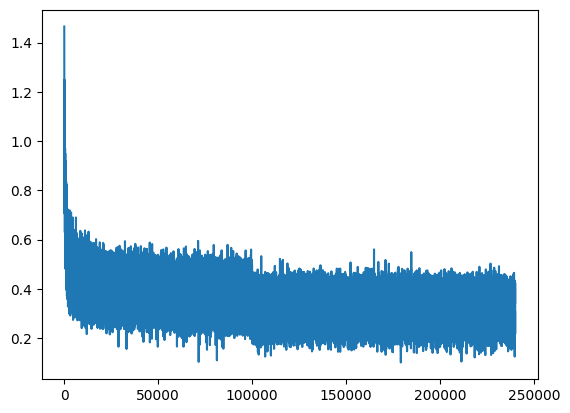

In [14]:
plt.plot(steps, losses)

In [20]:
def calculate_loss(X, Y):
    emb = C[X]
    h = torch.tanh(emb.view(emb.size(0), -1) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y)

    return loss

loss_tr = calculate_loss(Xtr, Ytr)
loss_val = calculate_loss(Xdev, Ydev)
loss_te = calculate_loss(Xte, Yte)

print(f"Training loss: {loss_tr}\nValidation loss: {loss_val}\nTest loss: {loss_te}")

Training loss: 2.096121072769165
Validation loss: 2.1500039100646973
Test loss: 2.158156633377075


Final losses after 100K iterations at learning rate = 0.1, 100K iterations at learning rate = 0.01 and 40K iterations at learning rate = 0.001:


Training: ~2.096 \
Validation: ~2.150 \
Test: ~2.158

In [22]:
g = torch.Generator().manual_seed(2147483647 + 19)

block_size = 3
for _ in range(10):
    
    out = []
    context = [0] * block_size# initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

devon.
balmiyah.
soum.
khon.
kiel.
matella.
asalea.
blyam.
hop.
vevia.
